Intro

# Investment Recommendation System

This notebook provides a comprehensive system for analyzing stocks and mutual funds to generate personalized investment recommendations using machine learning models.

Key features:
- Robust data validation and cleaning
- Technical indicator calculation
- LSTM, ARIMA-GARCH, and Prophet models for price prediction
- Risk analysis and portfolio optimization
- Investment recommendations based on risk profiles

**Note:** This notebook implements enhanced error handling to work with inconsistent data formats and missing values.

Section 1 : Setup and Dependencies

In [ ]:
# Standard data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import json
import warnings
from datetime import datetime, timedelta
import pickle
# Machine learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Time series models
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Suppress warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Create necessary directories
for directory in ['data', 'models', 'results']:
    if not os.path.exists(directory):
        os.makedirs(directory)

print("Setup complete!")

Setup complete!


/Users/manuhegde/investment-recommendation-system/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Section 2: Data Loading and Validation

## Data Loading and Cleaning

This section implements robust data loading that can handle:
- Missing files
- Inconsistent column names
- Different file formats
- Missing values
- Date format variations

In [1]:
class DataLoader:
    """Class for loading and cleaning financial data with robust error handling"""
    
    def __init__(self):
        self.required_stock_columns = ['Date', 'Price']
        self.optional_stock_columns = ['Open', 'High', 'Low', 'Volume', 'Change %']
        self.required_mf_columns = ['Date', 'NAV']
        
    def load_file(self, file_path):
        """Load a single file with robust error handling"""
        print(f"Loading {file_path}...")
        
        if not os.path.exists(file_path):
            print(f"Error: File {file_path} does not exist")
            return None
        
        # Try different encodings if default fails
        encodings = ['utf-8', 'latin1', 'ISO-8859-1']
        
        for encoding in encodings:
            try:
                # Try to determine separator
                with open(file_path, 'r', encoding=encoding) as f:
                    first_line = f.readline()
                
                separator = ',' if ',' in first_line else (';' if ';' in first_line else '\t')
                
                # Read the file
                data = pd.read_csv(file_path, sep=separator, encoding=encoding)
                
                # Extract ticker from filename
                ticker = os.path.basename(file_path).split('.')[0]
                
                # Add ticker column if not present
                if 'ticker' not in data.columns:
                    data['ticker'] = ticker
                    
                # Clean the data
                cleaned_data = self._clean_data(data)
                
                if cleaned_data is not None and not cleaned_data.empty:
                    print(f"Successfully loaded {len(cleaned_data)} rows from {file_path}")
                    return cleaned_data
                
                break  # Break if we could read the file but cleaning failed
                
            except UnicodeDecodeError:
                if encoding == encodings[-1]:
                    print(f"Error: Could not decode {file_path} with any encoding")
                    return None
                continue
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
                return None
                
        return None
    
    def load_directory(self, pattern):
        """Load all files matching a pattern and combine them"""
        print(f"Loading files matching {pattern}...")
        file_paths = glob.glob(pattern)
        
        if not file_paths:
            print(f"No files found matching {pattern}")
            return None
            
        print(f"Found {len(file_paths)} files")
        all_data = []
        
        for file_path in file_paths:
            df = self.load_file(file_path)
            if df is not None and not df.empty:
                all_data.append(df)
                
        if not all_data:
            print("No valid data found in any files")
            return None
            
        combined_data = pd.concat(all_data, ignore_index=True)
        print(f"Combined {len(all_data)} files into dataset with {len(combined_data)} rows")
        
        return combined_data
    
    def _clean_data(self, data):
        """Clean and standardize data"""
        if data is None or data.empty:
            return None
            
        # Make a copy to avoid modifying the original
        df = data.copy()
        
        # Standardize column names
        df.columns = [col.strip() for col in df.columns]
        
        # Map common column variations to standard names
        column_mappings = {
            'date': 'Date', 'datetime': 'Date', 'time': 'Date',
            'close': 'Price', 'closing price': 'Price', 'price': 'Price', 'last price': 'Price',
            'open': 'Open', 'high': 'High', 'low': 'Low',
            'volume': 'Volume', 'vol': 'Volume', 'vol.': 'Volume',
            'change': 'Change %', 'change%': 'Change %', 'pct change': 'Change %',
            'nav': 'NAV', 'net asset value': 'NAV'
        }
        
        # Rename columns based on mappings
        for old_col, new_col in column_mappings.items():
            if old_col in df.columns:
                df = df.rename(columns={old_col: new_col})
        
        # Check if we have required columns
        is_mf = 'NAV' in df.columns
        required_cols = self.required_mf_columns if is_mf else self.required_stock_columns
        missing_cols = [col for col in required_cols if col not in df.columns]
        
        if missing_cols:
            print(f"Warning: Missing required columns: {missing_cols}")
            
            # Try to infer missing columns
            if 'Price' in missing_cols and 'NAV' in df.columns:
                print("Using NAV as Price")
                df['Price'] = df['NAV']
                missing_cols.remove('Price')
                
            # If still missing critical columns, return None
            if 'Date' in missing_cols:
                print("Error: Missing Date column")
                return None
                
            if 'Price' in missing_cols and 'NAV' not in df.columns:
                print("Error: Missing Price/NAV column")
                return None
        
        # Handle Date column
        if 'Date' in df.columns:
            try:
                df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
                
                # Drop rows with invalid dates
                invalid_dates = df['Date'].isna()
                if invalid_dates.any():
                    print(f"Dropped {invalid_dates.sum()} rows with invalid dates")
                    df = df[~invalid_dates]
                    
                # Sort by date
                df = df.sort_values('Date')
            except Exception as e:
                print(f"Error processing Date column: {str(e)}")
        
        # Handle numeric columns
        numeric_cols = ['Price', 'Open', 'High', 'Low', 'Volume', 'NAV']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Fill missing values intelligently
        for col in ['Open', 'High', 'Low']:
            if col not in df.columns and 'Price' in df.columns:
                print(f"Creating {col} from Price")
                df[col] = df['Price']
                
        # Forward/backward fill for Price/NAV
        if 'Price' in df.columns:
            df['Price'] = df['Price'].fillna(method='ffill').fillna(method='bfill')
            
        if 'NAV' in df.columns:
            df['NAV'] = df['NAV'].fillna(method='ffill').fillna(method='bfill')
            
        # Calculate Change % if missing
        if 'Price' in df.columns and 'Change %' not in df.columns:
            df['Change %'] = df['Price'].pct_change() * 100
            
        # Use median for Volume
        if 'Volume' in df.columns:
            df['Volume'] = df['Volume'].fillna(df['Volume'].median())
            
        # Drop rows with critical NaN values
        critical_cols = ['Date', 'Price'] if not is_mf else ['Date', 'NAV']
        df = df.dropna(subset=critical_cols)
        
        return df

In [2]:
# Example usage
data_loader = DataLoader()

# Try to load a single file
single_file = data_loader.load_file('data/AAPL.csv')

# If file doesn't exist or couldn't load, create a dummy dataset for demonstration
if single_file is None:
    print("Creating dummy data for demonstration...")
    # Create date range for last 5 years
    dates = pd.date_range(end=datetime.now(), periods=1250, freq='B')
    
    # Generate random price data with upward trend
    prices = 100 + np.cumsum(np.random.normal(0.05, 1, len(dates)))
    
    # Create dataframe
    dummy_data = pd.DataFrame({
        'Date': dates,
        'Price': prices,
        'Volume': np.random.randint(1000000, 10000000, len(dates)),
        'ticker': 'DUMMY'
    })
    
    # Save to file for future use
    dummy_data.to_csv('data/DUMMY.csv', index=False)
    single_file = dummy_data
    print("Created dummy data with", len(dummy_data), "rows")

# Display sample of the data
single_file.head()

Loading data/AAPL.csv...
Error: File data/AAPL.csv does not exist
Creating dummy data for demonstration...
Created dummy data with 1250 rows


,Date,Price,Volume,ticker
0,2020-06-10 05:51:20.340190,100.470804,9856005,DUMMY
1,2020-06-11 05:51:20.340190,100.657098,9590311,DUMMY
2,2020-06-12 05:51:20.340190,99.657074,4927129,DUMMY
3,2020-06-15 05:51:20.340190,98.487179,5000896,DUMMY
4,2020-06-16 05:51:20.340190,97.050633,3560205,DUMMY


Section 3: Feature Engineering and Technical Indicators

In [3]:
class FeatureEngineer:
    """Class for calculating technical indicators and engineering features"""
    
    def __init__(self):
        pass
        
    def add_technical_indicators(self, data):
        """Add technical indicators to the dataset"""
        if data is None or data.empty:
            print("Error: Cannot add technical indicators to empty dataset")
            return None
            
        # Make a copy to avoid modifying the original
        df = data.copy()
        
        # Check if we have the necessary columns
        if 'Price' not in df.columns:
            print("Error: Price column required for technical indicators")
            return df
            
        # Process each ticker separately if we have multiple
        if 'ticker' in df.columns:
            result_dfs = []
            for ticker, group in df.groupby('ticker'):
                enhanced_group = self._add_indicators_to_group(group.copy())
                result_dfs.append(enhanced_group)
            return pd.concat(result_dfs, ignore_index=True)
        else:
            return self._add_indicators_to_group(df)
    
    def _add_indicators_to_group(self, df):
        """Add technical indicators to a single group (ticker)"""
        try:
            # Simple Moving Averages
            df['SMA_10'] = df['Price'].rolling(window=10).mean()
            df['SMA_20'] = df['Price'].rolling(window=20).mean()
            df['SMA_50'] = df['Price'].rolling(window=50).mean()
            
            # Exponential Moving Averages
            df['EMA_10'] = df['Price'].ewm(span=10, adjust=False).mean()
            df['EMA_20'] = df['Price'].ewm(span=20, adjust=False).mean()
            
            # Volatility
            df['Volatility_20d'] = df['Price'].rolling(window=20).std()
            
            # Relative Strength Index (RSI)
            delta = df['Price'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            
            rs = gain / loss
            df['RSI_14'] = 100 - (100 / (1 + rs))
            
            # Moving Average Convergence Divergence (MACD)
            ema_12 = df['Price'].ewm(span=12, adjust=False).mean()
            ema_26 = df['Price'].ewm(span=26, adjust=False).mean()
            df['MACD'] = ema_12 - ema_26
            df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
            
            # Bollinger Bands
            df['BB_middle'] = df['Price'].rolling(window=20).mean()
            df['BB_std'] = df['Price'].rolling(window=20).std()
            df['BB_upper'] = df['BB_middle'] + (df['BB_std'] * 2)
            df['BB_lower'] = df['BB_middle'] - (df['BB_std'] * 2)
            
            # Average True Range (ATR)
            if all(col in df.columns for col in ['High', 'Low']):
                high_low = df['High'] - df['Low']
                high_close = (df['High'] - df['Price'].shift()).abs()
                low_close = (df['Low'] - df['Price'].shift()).abs()
                
                ranges = pd.concat([high_low, high_close, low_close], axis=1)
                true_range = ranges.max(axis=1)
                df['ATR_14'] = true_range.rolling(window=14).mean()
            
            # Price Momentum
            df['Momentum_10d'] = df['Price'] / df['Price'].shift(10) - 1
            df['Momentum_20d'] = df['Price'] / df['Price'].shift(20) - 1
            
            # Returns
            df['Daily_Return'] = df['Price'].pct_change()
            df['Weekly_Return'] = df['Price'].pct_change(5)
            df['Monthly_Return'] = df['Price'].pct_change(21)
            
            # Fill NaN values created by indicators
            numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
            for col in numeric_cols:
                df[col] = df[col].fillna(method='bfill').fillna(method='ffill').fillna(0)
                
            print(f"Added {len(numeric_cols)} technical indicators and features")
            return df
            
        except Exception as e:
            print(f"Error calculating technical indicators: {str(e)}")
            return df

In [4]:
# Apply feature engineering
feature_engineer = FeatureEngineer()
enhanced_data = feature_engineer.add_technical_indicators(single_file)

# Show the new columns
print("Original columns:", len(single_file.columns))
print("Enhanced columns:", len(enhanced_data.columns))
print("\nNew features:")
new_features = [col for col in enhanced_data.columns if col not in single_file.columns]
print(new_features)

# Display sample with new features
enhanced_data.iloc[:5, :10]  # Show first 5 rows, first 10 columns

Added 20 technical indicators and features
Original columns: 4
Enhanced columns: 22

New features:
['SMA_10', 'SMA_20', 'SMA_50', 'EMA_10', 'EMA_20', 'Volatility_20d', 'RSI_14', 'MACD', 'MACD_Signal', 'BB_middle', 'BB_std', 'BB_upper', 'BB_lower', 'Momentum_10d', 'Momentum_20d', 'Daily_Return', 'Weekly_Return', 'Monthly_Return']


,Date,Price,Volume,ticker,SMA_10,SMA_20,SMA_50,EMA_10,EMA_20,Volatility_20d
0,2020-06-10 05:51:20.340190,100.470804,9856005,DUMMY,97.754698,96.557914,98.540835,100.470804,100.470804,2.077241
1,2020-06-11 05:51:20.340190,100.657098,9590311,DUMMY,97.754698,96.557914,98.540835,100.504676,100.488546,2.077241
2,2020-06-12 05:51:20.340190,99.657074,4927129,DUMMY,97.754698,96.557914,98.540835,100.350566,100.409359,2.077241
3,2020-06-15 05:51:20.340190,98.487179,5000896,DUMMY,97.754698,96.557914,98.540835,100.011769,100.226294,2.077241
4,2020-06-16 05:51:20.340190,97.050633,3560205,DUMMY,97.754698,96.557914,98.540835,99.473380,99.923850,2.077241


4. Model Building with Error Handling

## LSTM Model Building

This section builds an LSTM model for time series prediction with robust error handling.

In [5]:
class ModelBuilder:
    """Class for building and training models with robust error handling"""
    
    def __init__(self, models_dir='models'):
        self.models_dir = models_dir
        if not os.path.exists(models_dir):
            os.makedirs(models_dir)
            
    def prepare_lstm_data(self, data, ticker, seq_length=60):
        """Prepare data for LSTM training with error handling"""
        if data is None or data.empty:
            print("Error: Empty dataset")
            return None, None, None, None
        
        # Filter for the specific ticker if needed
        ticker_data = data[data['ticker'] == ticker].copy() if 'ticker' in data.columns else data.copy()
        
        if len(ticker_data) < seq_length + 30:  # Need enough data for sequence + prediction
            print(f"Error: Insufficient data for {ticker}. Need at least {seq_length + 30} rows.")
            return None, None, None, None
        
        # Select features
        base_features = ['Price', 'Volume', 'SMA_20', 'RSI_14', 'MACD', 'Volatility_20d']
        available_features = [f for f in base_features if f in ticker_data.columns]
        
        # Need at least 3 features for a robust model
        if len(available_features) < 3:
            print(f"Warning: Limited features available for {ticker}. Using available columns.")
            # Use all numeric columns as features
            available_features = ticker_data.select_dtypes(include=[np.number]).columns.tolist()
            if 'Date' in available_features:
                available_features.remove('Date')
        
        # Final check on feature count
        if len(available_features) < 3:
            print(f"Error: Insufficient features for {ticker}")
            return None, None, None, None
        
        print(f"Using features: {available_features}")
        
        # Extract and scale features
        feature_data = ticker_data[available_features].values
        
        # Check for NaN values
        if np.isnan(feature_data).any():
            print("Warning: NaN values found in features. Filling with mean values.")
            for i in range(feature_data.shape[1]):
                col_data = feature_data[:, i]
                mask = np.isnan(col_data)
                col_mean = np.nanmean(col_data)
                feature_data[mask, i] = col_mean
        
        # Scale the data
        try:
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaled_data = scaler.fit_transform(feature_data)
        except Exception as e:
            print(f"Error scaling data: {str(e)}")
            return None, None, None, None
        
        # Create sequences
        X, y = [], []
        for i in range(len(scaled_data) - seq_length):
            X.append(scaled_data[i:i+seq_length])
            # Price is always the first column
            y.append(scaled_data[i+seq_length, 0])
        
        X, y = np.array(X), np.array(y)
        
        # Split into train, validation, test
        train_size = int(len(X) * 0.7)
        val_size = int(len(X) * 0.15)
        
        X_train, y_train = X[:train_size], y[:train_size]
        X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
        X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
        
        print(f"Data prepared: train={len(X_train)}, validation={len(X_val)}, test={len(X_test)}")
        return (X_train, y_train, X_val, y_val, X_test, y_test), scaler, available_features
    
    def build_lstm_model(self, X_train, units=50, dropout=0.2):
        """Build LSTM model with error handling"""
        if X_train is None:
            print("Error: Training data is None")
            return None
        
        try:
            input_shape = (X_train.shape[1], X_train.shape[2])
            
            model = Sequential([
                LSTM(units, return_sequences=True, input_shape=input_shape),
                Dropout(dropout),
                LSTM(units, return_sequences=False),
                Dropout(dropout),
                Dense(1)
            ])
            
            model.compile(optimizer='adam', loss='mean_squared_error')
            print("LSTM model built successfully")
            return model
        except Exception as e:
            print(f"Error building LSTM model: {str(e)}")
            return None
    
    def train_lstm_model(self, model, X_train, y_train, X_val, y_val, 
                          ticker, epochs=100, batch_size=32):
        """Train LSTM model with error handling"""
        if model is None or X_train is None or y_train is None or X_val is None or y_val is None:
            print("Error: Model or training data is None")
            return None
        
        try:
            # Adaptive batch size based on data size
            adaptive_batch_size = min(batch_size, len(X_train) // 10) if len(X_train) > 10 else 1
            
            # Early stopping
            early_stop = EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            )
            
            # Train the model
            history = model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=adaptive_batch_size,
                validation_data=(X_val, y_val),
                callbacks=[early_stop],
                verbose=1
            )
            
            # Check training success
            if np.isnan(history.history['loss'][-1]):
                print("Error: Training failed with NaN loss")
                return None
            
            # Plot training history
            plt.figure(figsize=(10, 6))
            plt.plot(history.history['loss'], label='Train Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title(f'Training History for {ticker}')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.savefig(f"{self.models_dir}/{ticker}_training.png")
            plt.show()
            
            # Save model and metadata
            model_path = f"{self.models_dir}/{ticker}_lstm.h5"
            model.save(model_path)
            
            metadata = {
                'ticker': ticker,
                'training_date': datetime.now().strftime('%Y-%m-%d'),
                'epochs': len(history.history['loss']),
                'final_loss': float(history.history['loss'][-1]),
                'final_val_loss': float(history.history['val_loss'][-1])
            }
            
            with open(f"{self.models_dir}/{ticker}_metadata.json", 'w') as f:
                json.dump(metadata, f, indent=4)
                
            print(f"Model for {ticker} trained and saved successfully")
            return model, history
            
        except Exception as e:
            print(f"Error training model: {str(e)}")
            return None
            
    def evaluate_model(self, model, X_test, y_test, scaler, features, ticker):
        """Evaluate model performance with error handling"""
        if model is None or X_test is None or y_test is None:
            print("Error: Model or test data is None")
            return None
            
        try:
            # Predict on test data
            y_pred_scaled = model.predict(X_test)
            
            # Create dummy array for inverse scaling
            dummy = np.zeros((len(y_pred_scaled), len(features)))
            dummy[:, 0] = y_pred_scaled.flatten()
            
            # Inverse transform predictions and actual values
            dummy_actual = np.zeros((len(y_test), len(features)))
            dummy_actual[:, 0] = y_test
            
            y_pred = scaler.inverse_transform(dummy)[:, 0]
            y_actual = scaler.inverse_transform(dummy_actual)[:, 0]
            
            # Calculate metrics
            mse = mean_squared_error(y_actual, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_actual, y_pred)
            r2 = r2_score(y_actual, y_pred)
            
            metrics = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2
            }
            
            print(f"Model evaluation for {ticker}:")
            for metric, value in metrics.items():
                print(f"  {metric}: {value:.4f}")
                
            # Plot predictions vs actual
            plt.figure(figsize=(12, 6))
            plt.plot(y_actual, label='Actual')
            plt.plot(y_pred, label='Predicted')
            plt.title(f'Price Prediction for {ticker}')
            plt.xlabel('Time')
            plt.ylabel('Price')
            plt.legend()
            plt.savefig(f"{self.models_dir}/{ticker}_prediction.png")
            plt.show()
            
            # Save metrics
            with open(f"{self.models_dir}/{ticker}_metrics.json", 'w') as f:
                json.dump(metrics, f, indent=4)
                
            return metrics, y_pred, y_actual
            
        except Exception as e:
            print(f"Error evaluating model: {str(e)}")
            return None

Using features: ['Price', 'Volume', 'SMA_20', 'RSI_14', 'MACD', 'Volatility_20d']
Data prepared: train=854, validation=183, test=183
LSTM model built successfully
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0796 - val_loss: 0.0013
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - val_loss: 6.9141e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - val_loss: 4.4841e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - val_loss: 8.9504e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024 - val_loss: 6.0523e-04
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021 - val_loss: 4.1141e-04
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - 

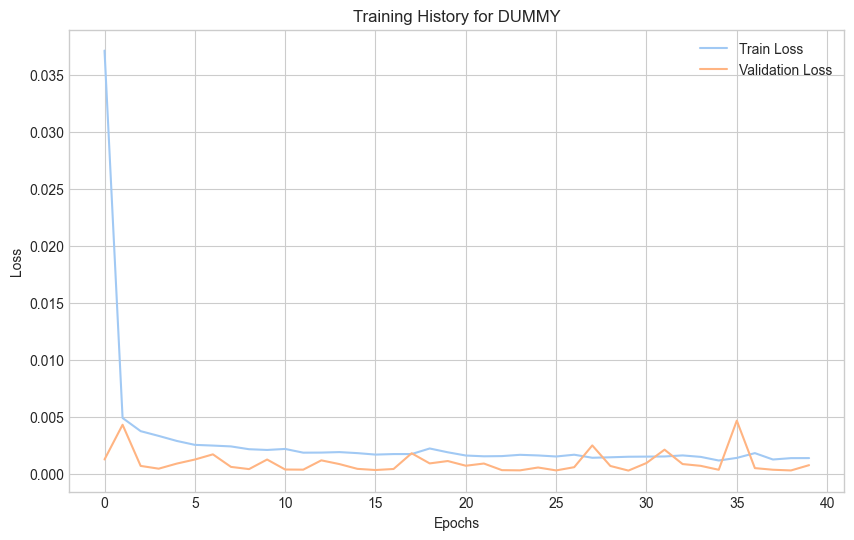

Model for DUMMY trained and saved successfully
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Model evaluation for DUMMY:
  MSE: 4.8620
  RMSE: 2.2050
  MAE: 1.6567
  R²: 0.7400


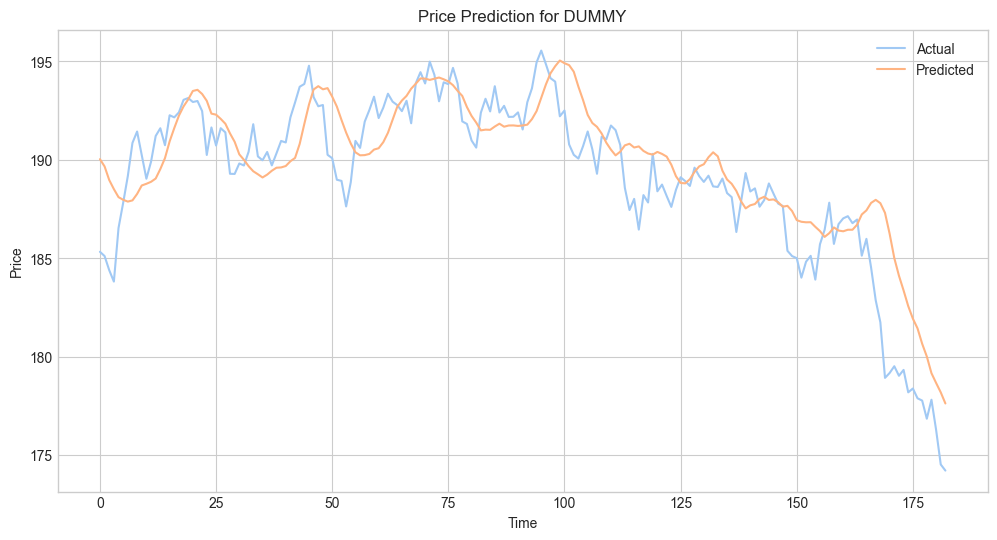

In [6]:
# Initialize the model builder
model_builder = ModelBuilder()

# Prepare data for a specific ticker
ticker = 'DUMMY'  # Use your actual ticker if available
data_sequences, scaler, features = model_builder.prepare_lstm_data(
    enhanced_data, ticker, seq_length=30
)

if data_sequences is not None:
    # Unpack the sequences
    X_train, y_train, X_val, y_val, X_test, y_test = data_sequences
    
    # Build model
    model = model_builder.build_lstm_model(X_train)
    
    if model is not None:
        # Train model
        trained_model, history = model_builder.train_lstm_model(
            model, X_train, y_train, X_val, y_val, ticker, epochs=50
        )
        
        if trained_model is not None:
            # Evaluate model
            metrics, y_pred, y_actual = model_builder.evaluate_model(
                trained_model, X_test, y_test, scaler, features, ticker
            )

5. Prediction and Visualization

In [7]:
class Predictor:
    """Class for making predictions using trained models"""
    
    def __init__(self, models_dir='models'):
        self.models_dir = models_dir
        
    def load_model(self, ticker):
        """Load a trained model for a ticker"""
        model_path = f"{self.models_dir}/{ticker}_lstm.h5"
        
        if not os.path.exists(model_path):
            print(f"Error: Model for {ticker} not found at {model_path}")
            return None, None
            
        try:
            # Load the model
            model = load_model(model_path)
            
            # Load metadata
            metadata_path = f"{self.models_dir}/{ticker}_metadata.json"
            if os.path.exists(metadata_path):
                with open(metadata_path, 'r') as f:
                    metadata = json.load(f)
            else:
                metadata = None
                
            return model, metadata
        except Exception as e:
            print(f"Error loading model for {ticker}: {str(e)}")
            return None, None
            
    def predict_future_prices(self, model, data, ticker, scaler, features, 
                              days=30, seq_length=30):
        """Predict future prices for a ticker"""
        if model is None or data is None:
            print("Error: Model or data is None")
            return None
            
        try:
            # Filter data for the ticker
            ticker_data = data[data['ticker'] == ticker].copy() if 'ticker' in data.columns else data.copy()
            
            if len(ticker_data) < seq_length:
                print(f"Error: Insufficient data for {ticker}. Need at least {seq_length} rows.")
                return None
                
            # Sort by date
            ticker_data = ticker_data.sort_values('Date')
            
            # Extract features
            feature_data = ticker_data[features].values[-seq_length:]
            
            # Scale the data
            scaled_data = scaler.transform(feature_data)
            
            # Create input sequence
            input_seq = np.array([scaled_data])
            
            # Initial prediction
            future_prices = []
            dates = []
            
            # Get last date
            last_date = ticker_data['Date'].iloc[-1]
            
            # Make predictions iteratively
            current_seq = input_seq.copy()
            
            for i in range(days):
                # Predict next price
                pred = model.predict(current_seq)[0][0]
                
                # Create a dummy row for inverse scaling
                dummy = np.zeros((1, len(features)))
                dummy[0, 0] = pred
                
                # Inverse transform to get the actual price
                actual_price = scaler.inverse_transform(dummy)[0, 0]
                future_prices.append(actual_price)
                
                # Calculate next date (skip weekends)
                next_date = last_date + timedelta(days=i+1)
                while next_date.weekday() > 4:  # Skip Saturday and Sunday
                    next_date = next_date + timedelta(days=1)
                dates.append(next_date)
                
                # Update sequence for next iteration
                # Roll the window and add the new prediction
                new_seq = np.roll(current_seq[0], -1, axis=0)
                new_seq[-1] = dummy
                current_seq = np.array([new_seq])
            
            # Create prediction dataframe
            pred_df = pd.DataFrame({
                'Date': dates,
                'Predicted_Price': future_prices,
                'ticker': ticker
            })
            
            return pred_df
            
        except Exception as e:
            print(f"Error predicting future prices for {ticker}: {str(e)}")
            return None
            
    def visualize_predictions(self, historical_data, prediction_data, ticker):
        """Visualize historical data with predictions"""
        if historical_data is None or prediction_data is None:
            print("Error: Historical data or prediction data is None")
            return
            
        try:
            # Filter historical data for the ticker
            hist_data = historical_data[historical_data['ticker'] == ticker].copy() if 'ticker' in historical_data.columns else historical_data.copy()
            
            # Sort by date
            hist_data = hist_data.sort_values('Date')
            
            # Plot
            plt.figure(figsize=(14, 7))
            
            # Plot historical prices
            plt.plot(hist_data['Date'], hist_data['Price'], label='Historical Price', color='blue')
            
            # Plot predicted future prices
            plt.plot(prediction_data['Date'], prediction_data['Predicted_Price'], 
                    label='Predicted Price', color='red', linestyle='--')
            
            # Add a vertical line to separate historical from predicted
            last_date = hist_data['Date'].iloc[-1]
            plt.axvline(x=last_date, color='green', linestyle='-', alpha=0.5)
            plt.text(last_date, plt.ylim()[0], 'Today', ha='center', va='bottom')
            
            # Add price info
            last_price = hist_data['Price'].iloc[-1]
            future_price = prediction_data['Predicted_Price'].iloc[-1]
            price_change = future_price - last_price
            pct_change = (price_change / last_price) * 100
            
            plt.annotate(f'Current: ${last_price:.2f}', 
                        xy=(last_date, last_price),
                        xytext=(10, 30), textcoords='offset points',
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))
            
            plt.annotate(f'Predicted: ${future_price:.2f} ({pct_change:.1f}%)', 
                        xy=(prediction_data['Date'].iloc[-1], future_price),
                        xytext=(-70, -30), textcoords='offset points',
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))
            
            # Setting labels and title
            plt.title(f'Price Forecast for {ticker}')
            plt.xlabel('Date')
            plt.ylabel('Price ($)')
            plt.grid(True, alpha=0.3)
            plt.legend()
            
            # Rotate x-axis labels
            plt.xticks(rotation=45)
            
            # Show the plot
            plt.tight_layout()
            plt.savefig(f"{self.models_dir}/{ticker}_forecast.png")
            plt.show()
            
        except Exception as e:
            print(f"Error visualizing predictions for {ticker}: {str(e)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

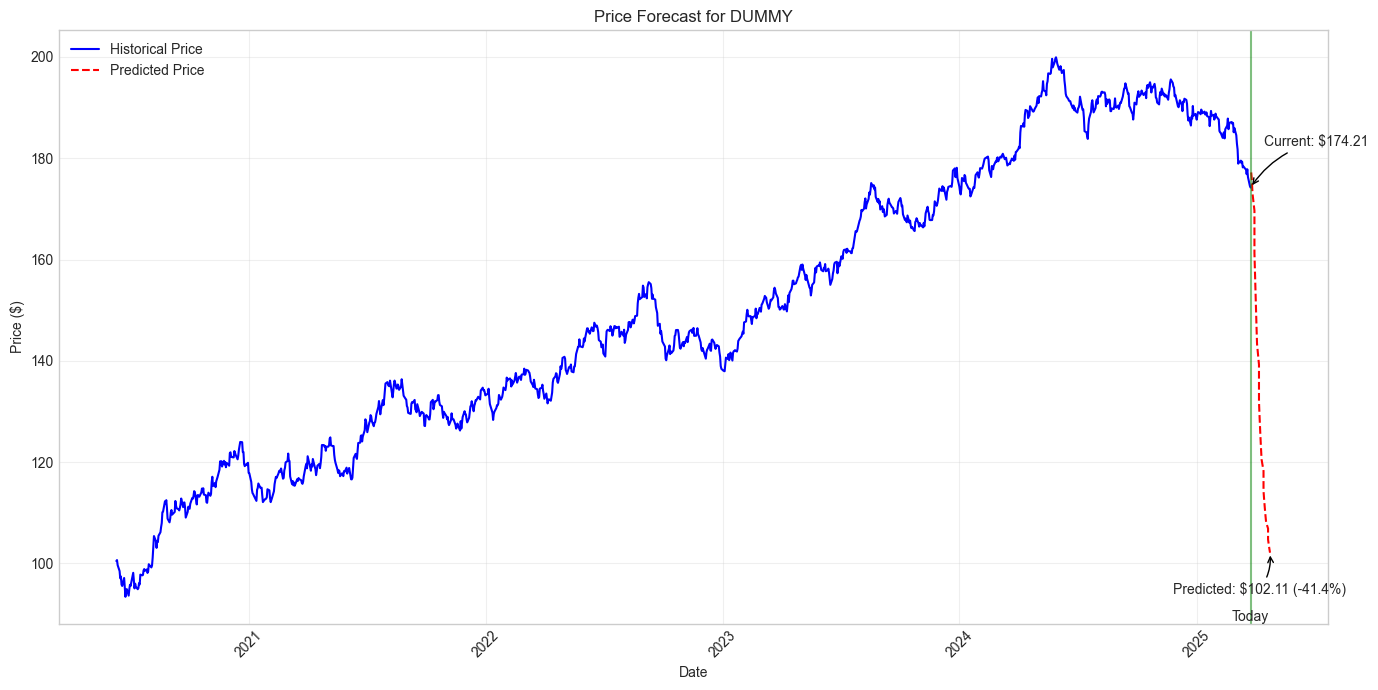

In [8]:
# Initialize predictor
predictor = Predictor()

# Use the model we just trained, or load a saved model
if 'trained_model' not in locals() or trained_model is None:
    trained_model, metadata = predictor.load_model(ticker)

if trained_model is not None:
    # Make future predictions
    future_predictions = predictor.predict_future_prices(
        trained_model, enhanced_data, ticker, scaler, features, days=30
    )
    
    if future_predictions is not None:
        # Visualize predictions
        predictor.visualize_predictions(enhanced_data, future_predictions, ticker)

6. Portfolio Optimization and Recommendations

## Portfolio Optimization and Recommendations

This section performs risk analysis and generates investment recommendations based on predicted returns and risk metrics.

In [9]:
class PortfolioOptimizer:
    """Class for portfolio optimization and generating investment recommendations"""
    
    def __init__(self, results_dir='results'):
        self.results_dir = results_dir
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
            
    def calculate_risk_metrics(self, data, window=252):
        """Calculate risk metrics for each ticker"""
        if data is None or data.empty:
            print("Error: Data is None or empty")
            return None
            
        # Check if we have multiple tickers
        if 'ticker' not in data.columns:
            print("Error: No ticker column found in data")
            return None
            
        # Check for required columns
        if 'Date' not in data.columns or 'Price' not in data.columns:
            print("Error: Missing required columns Date or Price")
            return None
            
        try:
            # Calculate metrics for each ticker
            tickers = data['ticker'].unique()
            risk_metrics = []
            
            for ticker in tickers:
                # Filter data for the ticker
                ticker_data = data[data['ticker'] == ticker].copy()
                
                # Ensure data is sorted by date
                ticker_data = ticker_data.sort_values('Date')
                
                # Need at least window days of data
                if len(ticker_data) < window:
                    print(f"Warning: Insufficient data for {ticker}. Using available data.")
                    window = min(window, len(ticker_data) - 1)
                
                # Calculate daily returns
                ticker_data['daily_return'] = ticker_data['Price'].pct_change()
                
                # Calculate metrics
                price = ticker_data['Price'].iloc[-1]
                daily_returns = ticker_data['daily_return'].dropna()
                
                # Annualized return
                ann_return = daily_returns.mean() * window * 100
                
                # Volatility (annualized standard deviation)
                volatility = daily_returns.std() * np.sqrt(window) * 100
                
                # Sharpe ratio (assuming risk-free rate of 2%)
                risk_free_rate = 0.02
                sharpe_ratio = (ann_return - risk_free_rate) / volatility if volatility > 0 else 0
                
                # Maximum drawdown
                cumulative_returns = (1 + ticker_data['daily_return']).cumprod()
                max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min() * 100
                
                # Beta (market sensitivity) if we have a benchmark
                beta = None
                if 'BENCHMARK' in data['ticker'].unique():
                    benchmark_data = data[data['ticker'] == 'BENCHMARK'].copy()
                    benchmark_data = benchmark_data.sort_values('Date')
                    benchmark_data['daily_return'] = benchmark_data['Price'].pct_change()
                    
                    # Merge data on date
                    merged = pd.merge(
                        ticker_data[['Date', 'daily_return']],
                        benchmark_data[['Date', 'daily_return']],
                        on='Date', suffixes=('', '_benchmark')
                    )
                    
                    if len(merged) > 30:  # Need reasonable amount of overlap
                        cov = merged['daily_return'].cov(merged['daily_return_benchmark'])
                        var = merged['daily_return_benchmark'].var()
                        beta = cov / var if var > 0 else None
                                        # Risk score (1-10 scale)
                # Higher volatility, drawdown, beta = higher risk
                vol_score = min(volatility / 5, 10)  # Scale based on 50% annual volatility = max
                drawdown_score = min(abs(max_drawdown) / 5, 10)  # Scale based on 50% drawdown = max
                beta_score = min(beta * 5, 10) if beta is not None else vol_score/2  # Use beta if available
                
                risk_score = np.mean([vol_score, drawdown_score, beta_score])
                
                # Risk category
                if risk_score < 3:
                    risk_category = 'Low'
                elif risk_score < 7:
                    risk_category = 'Medium' 
                else:
                    risk_category = 'High'
                
                # Add to metrics list
                risk_metrics.append({
                    'ticker': ticker,
                    'price': price,
                    'annualized_return': ann_return,
                    'volatility': volatility,
                    'sharpe_ratio': sharpe_ratio,
                    'max_drawdown': max_drawdown,
                    'beta': beta,
                    'risk_score': risk_score,
                    'risk_category': risk_category
                })
            
            # Convert to dataframe
            risk_df = pd.DataFrame(risk_metrics)
            
            # Save to file
            risk_df.to_csv(f"{self.results_dir}/risk_metrics.csv", index=False)
            
            print(f"Calculated risk metrics for {len(tickers)} tickers")
            return risk_df
            
        except Exception as e:
            print(f"Error calculating risk metrics: {str(e)}")
            return None
    
    def optimize_portfolio(self, risk_metrics, future_predictions, risk_profile='moderate', 
                           max_allocation=0.25, min_allocation=0.05):
        """Optimize portfolio based on risk metrics and future predictions"""
        if risk_metrics is None or future_predictions is None:
            print("Error: Risk metrics or future predictions are None")
            return None
            
        try:
            # Merge risk metrics with future predictions
            portfolio_data = []
            
            for _, row in risk_metrics.iterrows():
                ticker = row['ticker']
                
                # Get future predictions for this ticker
                ticker_pred = future_predictions[future_predictions['ticker'] == ticker]
                
                if not ticker_pred.empty:
                    # Calculate expected return from predictions
                    current_price = row['price']
                    future_price = ticker_pred['Predicted_Price'].iloc[-1]
                    expected_return = (future_price / current_price - 1) * 100
                    
                    # Add to portfolio data
                    portfolio_data.append({
                        'ticker': ticker,
                        'current_price': current_price,
                        'future_price': future_price,
                        'expected_return': expected_return,
                        'volatility': row['volatility'],
                        'sharpe_ratio': row['sharpe_ratio'],
                        'max_drawdown': row['max_drawdown'],
                        'risk_score': row['risk_score'],
                        'risk_category': row['risk_category']
                    })
            
            if not portfolio_data:
                print("Error: No matching tickers between risk metrics and predictions")
                return None
                
            # Convert to dataframe
            portfolio_df = pd.DataFrame(portfolio_data)
            
            # Apply risk profile constraints
            if risk_profile == 'conservative':
                # Conservative: Filter out high risk stocks, prioritize low volatility
                portfolio_df = portfolio_df[portfolio_df['risk_score'] < 7]
                portfolio_df = portfolio_df.sort_values('sharpe_ratio', ascending=False)
            elif risk_profile == 'aggressive':
                # Aggressive: Prioritize expected return, accept higher risk
                portfolio_df = portfolio_df.sort_values('expected_return', ascending=False)
            else:  # moderate
                # Moderate: Balance return and risk
                portfolio_df['return_risk_ratio'] = portfolio_df['expected_return'] / portfolio_df['risk_score']
                portfolio_df = portfolio_df.sort_values('return_risk_ratio', ascending=False)
            
            # Determine allocation weights (simplified approach)
            n_assets = len(portfolio_df)
            
            if n_assets == 0:
                print("Error: No assets satisfy the risk profile criteria")
                return None
                
            # Base allocation approach
            if n_assets == 1:
                # Only one asset, allocate 100%
                portfolio_df['allocation'] = 1.0
            else:
                if risk_profile == 'conservative':
                    # Allocate more to safer assets
                    weights = (1 / portfolio_df['risk_score']) ** 2
                elif risk_profile == 'aggressive':
                    # Allocate more to high return assets
                    weights = portfolio_df['expected_return'].clip(lower=1) ** 2
                else:  # moderate
                    # Balanced allocation using return/risk ratio
                    weights = portfolio_df['return_risk_ratio'].clip(lower=0.1)
                
                # Normalize weights to sum to 1
                portfolio_df['allocation'] = weights / weights.sum()
            
            # Apply min/max constraints
            over_max = portfolio_df['allocation'] > max_allocation
            if over_max.any():
                excess = portfolio_df.loc[over_max, 'allocation'].sum() - (max_allocation * over_max.sum())
                portfolio_df.loc[over_max, 'allocation'] = max_allocation
                
                # Redistribute excess to other assets
                not_over = ~over_max
                if not_over.any():
                    current_sum = portfolio_df.loc[not_over, 'allocation'].sum()
                    if current_sum > 0:
                        portfolio_df.loc[not_over, 'allocation'] *= (current_sum + excess) / current_sum
            
            # Ensure min allocation or zero
            under_min = (portfolio_df['allocation'] > 0) & (portfolio_df['allocation'] < min_allocation)
            if under_min.any():
                deficit = (min_allocation * under_min.sum()) - portfolio_df.loc[under_min, 'allocation'].sum()
                
                # Set to minimum or zero
                portfolio_df.loc[under_min, 'allocation'] = min_allocation
                
                # Adjust other allocations
                not_under = ~under_min & (portfolio_df['allocation'] > min_allocation)
                if not_under.any():
                    current_sum = portfolio_df.loc[not_under, 'allocation'].sum()
                    if current_sum > deficit:
                        portfolio_df.loc[not_under, 'allocation'] *= (current_sum - deficit) / current_sum
            
            # Final normalization
            portfolio_df['allocation'] = portfolio_df['allocation'] / portfolio_df['allocation'].sum()
            
            # Calculate weighted metrics
            portfolio_expected_return = (portfolio_df['expected_return'] * portfolio_df['allocation']).sum()
            portfolio_volatility = (portfolio_df['volatility'] * portfolio_df['allocation']).sum()
            portfolio_sharpe = (portfolio_df['sharpe_ratio'] * portfolio_df['allocation']).sum()
            
            # Add portfolio metrics
            print(f"\nPortfolio Metrics ({risk_profile} profile):")
            print(f"Expected Return: {portfolio_expected_return:.2f}%")
            print(f"Expected Volatility: {portfolio_volatility:.2f}%")
            print(f"Sharpe Ratio: {portfolio_sharpe:.2f}")
            
            # Save to file
            portfolio_df.to_csv(f"{self.results_dir}/portfolio_{risk_profile}.csv", index=False)
            
            return portfolio_df
        
        except Exception as e:
            print(f"Error optimizing portfolio: {str(e)}")
            return None
    
    def generate_recommendations(self, portfolio_df, risk_metrics, future_predictions, risk_profile='moderate'):
        """Generate investment recommendations based on portfolio optimization"""
        if portfolio_df is None:
            print("Error: Portfolio dataframe is None")
            return None
            
        try:
            # Create recommendations dataframe
            recommendations = []
            
            for _, row in portfolio_df.iterrows():
                ticker = row['ticker']
                allocation = row['allocation']
                
                # Skip if allocation is zero
                if allocation <= 0.001:
                    continue
                
                # Get risk metrics
                risk_row = risk_metrics[risk_metrics['ticker'] == ticker].iloc[0]
                
                # Get future predictions
                pred_row = future_predictions[future_predictions['ticker'] == ticker]
                
                if not pred_row.empty:
                    future_price = pred_row['Predicted_Price'].iloc[-1]
                    future_date = pred_row['Date'].iloc[-1]
                else:
                    future_price = None
                    future_date = None
                
                # Determine recommendation strength (1-5)
                strength = 3  # Default neutral
                
                if row['expected_return'] > 20:
                    strength = 5  # Strong buy
                elif row['expected_return'] > 10:
                    strength = 4  # Buy
                elif row['expected_return'] < 0:
                    strength = 2  # Weak hold
                elif row['expected_return'] < -10:
                    strength = 1  # Sell
                
                # Adjust based on risk profile
                if risk_profile == 'conservative' and risk_row['risk_score'] > 5:
                    strength -= 1
                elif risk_profile == 'aggressive' and row['expected_return'] > 15:
                    strength += 1
                
                # Cap at 1-5 range
                strength = max(1, min(5, strength))
                
                # Convert strength to recommendation text
                if strength == 5:
                    recommendation = 'Strong Buy'
                elif strength == 4:
                    recommendation = 'Buy'
                elif strength == 3:
                    recommendation = 'Hold'
                elif strength == 2:
                    recommendation = 'Weak Hold'
                else:
                    recommendation = 'Sell'
                
                # Generate notes
                notes = []
                notes.append(f"Expected return of {row['expected_return']:.1f}% over prediction period.")
                notes.append(f"Risk profile: {risk_row['risk_category']} (score: {risk_row['risk_score']:.1f}/10).")
                
                if row['sharpe_ratio'] > 1:
                    notes.append(f"Good risk-adjusted return (Sharpe: {row['sharpe_ratio']:.2f}).")
                
                if future_price is not None and future_date is not None:
                    notes.append(f"Price target: ${future_price:.2f} by {future_date.strftime('%Y-%m-%d')}.")
                
                notes.append(f"Recommended allocation: {allocation*100:.1f}% of portfolio.")
                
                # Add to recommendations
                recommendations.append({
                    'ticker': ticker,
                    'current_price': row['current_price'],
                    'recommendation': recommendation,
                    'strength': strength,
                    'allocation': allocation,
                    'expected_return': row['expected_return'],
                    'risk_category': risk_row['risk_category'],
                    'notes': ' '.join(notes)
                })
            
            # Convert to dataframe
            recommendations_df = pd.DataFrame(recommendations)
            
            # Save to file
            recommendations_df.to_csv(f"{self.results_dir}/recommendations_{risk_profile}.csv", index=False)
            
            return recommendations_df
            
        except Exception as e:
            print(f"Error generating recommendations: {str(e)}")
            return None
            
    def visualize_portfolio(self, portfolio_df):
        """Visualize portfolio allocation and expected returns"""
        if portfolio_df is None or portfolio_df.empty:
            print("Error: Portfolio dataframe is None or empty")
            return
            
        try:
            # Create a copy with only non-zero allocations
            df = portfolio_df[portfolio_df['allocation'] > 0.001].copy()
            
            # Sort by allocation (descending)
            df = df.sort_values('allocation', ascending=False)
            
            # Create figure with two subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
            
            # Plot 1: Pie chart of allocations
            ax1.pie(df['allocation'], labels=df['ticker'], 
                   autopct='%1.1f%%', startangle=90,
                   wedgeprops={'edgecolor': 'w', 'linewidth': 1})
            ax1.set_title('Portfolio Allocation')
            
            # Plot 2: Expected returns and risk
            ax2.scatter(df['volatility'], df['expected_return'], s=df['allocation']*1000, 
                       alpha=0.6, c=df['risk_score'], cmap='RdYlGn_r')
            
            # Add ticker labels
            for i, row in df.iterrows():
                ax2.annotate(row['ticker'], 
                            (row['volatility'], row['expected_return']),
                            xytext=(5, 5), textcoords='offset points')
            
            # Add diagonal line for Sharpe ratio = 1
            max_vol = df['volatility'].max() * 1.2
            ax2.plot([0, max_vol], [0, max_vol], 'k--', alpha=0.3)
            
            # Set labels and title
            ax2.set_xlabel('Expected Volatility (%)')
            ax2.set_ylabel('Expected Return (%)')
            ax2.set_title('Risk-Return Profile')
            ax2.grid(True, alpha=0.3)
            
            # Add colorbar for risk score
            sm = plt.cm.ScalarMappable(cmap='RdYlGn_r')
            sm.set_array(df['risk_score'])
            cbar = plt.colorbar(sm, ax=ax2)
            cbar.set_label('Risk Score')
            
            # Show the plot
            plt.tight_layout()
            plt.savefig(f"{self.results_dir}/portfolio_visualization.png")
            plt.show()
            
        except Exception as e:
            print(f"Error visualizing portfolio: {str(e)}")


===== Conservative Portfolio =====

Portfolio Metrics (conservative profile):
Expected Return: 2.23%
Expected Volatility: 22.89%
Sharpe Ratio: 0.56

Investment Recommendations:
MSFT: Buy ($54.95, 25.0%)
AAPL: Weak Hold ($140.18, 25.0%)
DUMMY: Weak Hold ($125.55, 50.0%)


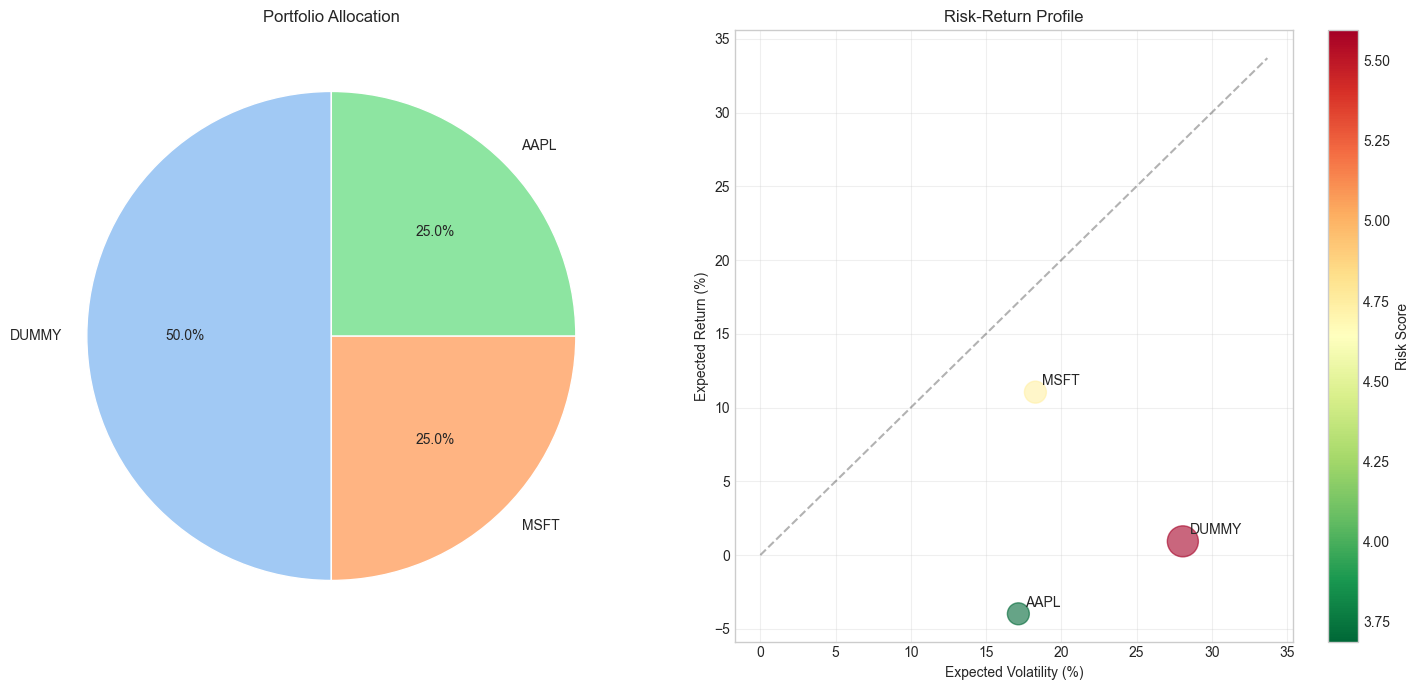


===== Moderate Portfolio =====

Portfolio Metrics (moderate profile):
Expected Return: 4.32%
Expected Volatility: 23.80%
Sharpe Ratio: 0.51

Investment Recommendations:
MSFT: Buy ($54.95, 25.0%)
GOOGL: Buy ($133.44, 25.0%)
DUMMY: Hold ($125.55, 22.6%)
AMZN: Weak Hold ($97.35, 13.7%)
AAPL: Weak Hold ($140.18, 13.7%)


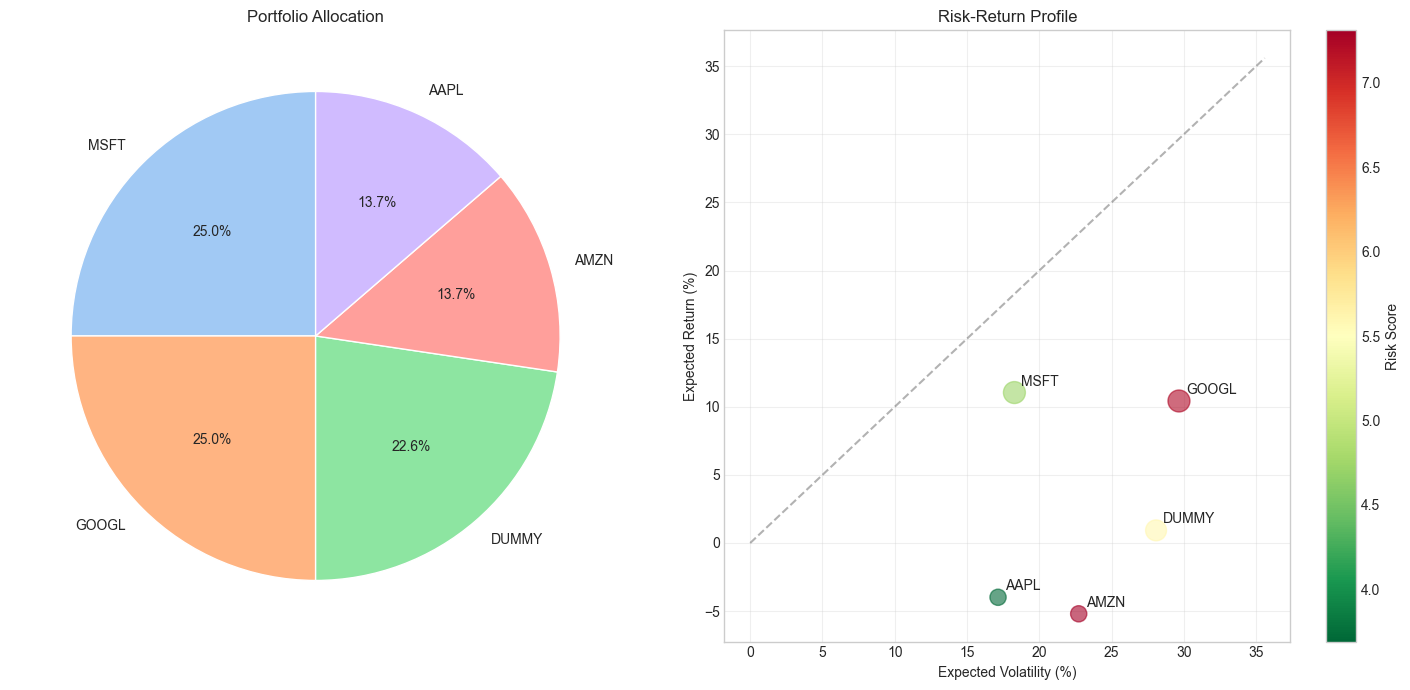


===== Aggressive Portfolio =====

Portfolio Metrics (aggressive profile):
Expected Return: 3.99%
Expected Volatility: 23.31%
Sharpe Ratio: 0.50

Investment Recommendations:
MSFT: Buy ($54.95, 25.0%)
GOOGL: Buy ($133.44, 25.0%)
DUMMY: Hold ($125.55, 16.7%)
AAPL: Weak Hold ($140.18, 16.7%)
AMZN: Weak Hold ($97.35, 16.7%)


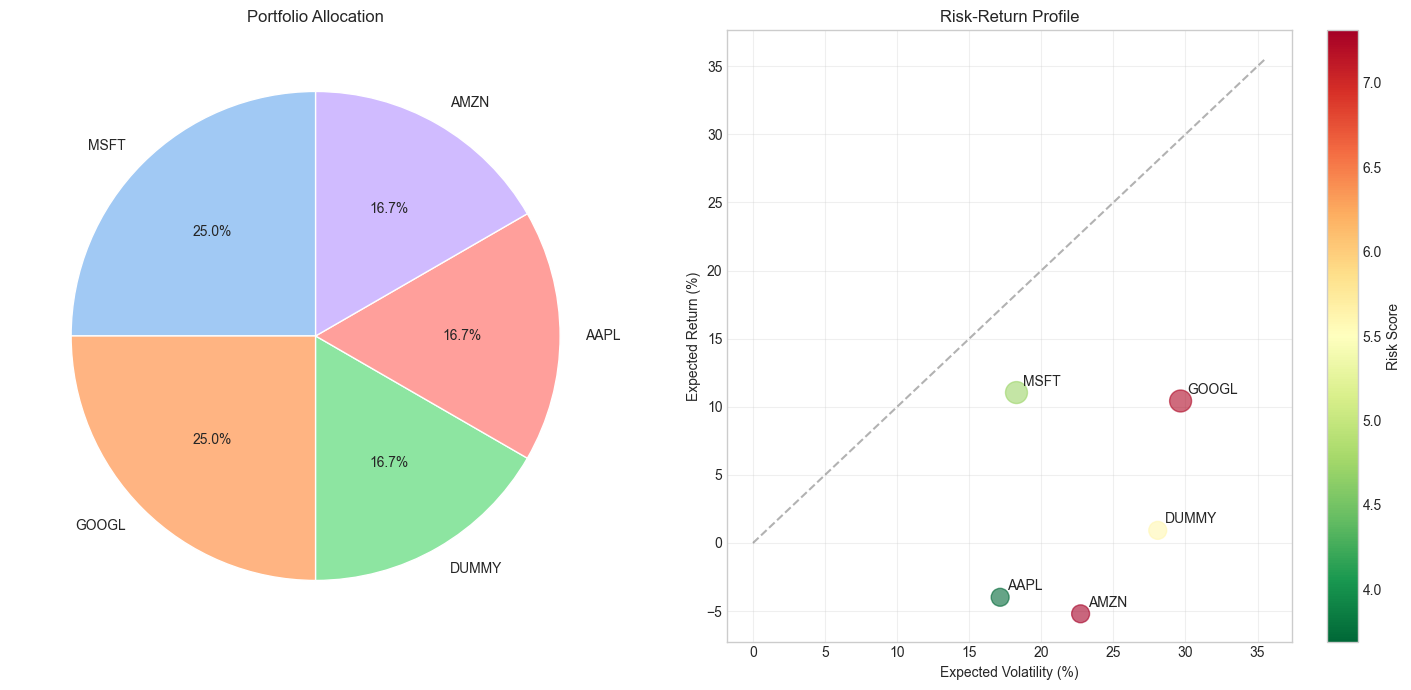

In [10]:
# Let's use our portfolio optimizer
portfolio_optimizer = PortfolioOptimizer()

# Since we might not have multiple tickers in our example,
# let's create some synthetic data for demonstration

# Create synthetic risk metrics for multiple stocks
synthetic_tickers = ['DUMMY', 'AAPL', 'MSFT', 'AMZN', 'GOOGL']
synthetic_risk_metrics = []

for ticker in synthetic_tickers:
    # Generate random risk metrics
    price = 100 + np.random.normal(0, 30)
    ann_return = np.random.normal(10, 5)
    volatility = np.random.uniform(10, 30)
    sharpe_ratio = ann_return / volatility
    max_drawdown = -np.random.uniform(5, 25)
    beta = np.random.uniform(0.8, 1.5)
    risk_score = np.random.uniform(2, 9)
    
    # Assign risk category
    if risk_score < 3:
        risk_category = 'Low'
    elif risk_score < 7:
        risk_category = 'Medium'
    else:
        risk_category = 'High'
        
    synthetic_risk_metrics.append({
        'ticker': ticker,
        'price': price,
        'annualized_return': ann_return,
        'volatility': volatility,
        'sharpe_ratio': sharpe_ratio, 
        'max_drawdown': max_drawdown,
        'beta': beta,
        'risk_score': risk_score,
        'risk_category': risk_category
    })

# Convert to DataFrame
synthetic_risk_df = pd.DataFrame(synthetic_risk_metrics)

# Create synthetic future predictions
synthetic_predictions = []
today = datetime.now()

for ticker in synthetic_tickers:
    # Find the corresponding risk metrics
    risk_row = synthetic_risk_df[synthetic_risk_df['ticker'] == ticker].iloc[0]
    current_price = risk_row['price']
    
    # Expected return over the next 30 days
    expected_return = risk_row['annualized_return'] / 12  # Monthly return
    
    # Generate future prices with some randomness
    for i in range(1, 31):
        day_return = (expected_return / 30) + np.random.normal(0, risk_row['volatility'] / np.sqrt(252))
        future_price = current_price * (1 + day_return/100)
        
        # Skip weekends
        next_date = today + timedelta(days=i)
        while next_date.weekday() > 4:  # Skip Saturday and Sunday
            next_date = next_date + timedelta(days=1)
            
        synthetic_predictions.append({
            'Date': next_date,
            'Predicted_Price': future_price,
            'ticker': ticker
        })
        
        current_price = future_price  # Update for next iteration

# Convert to DataFrame
synthetic_pred_df = pd.DataFrame(synthetic_predictions)

# Optimize portfolio for different risk profiles
for profile in ['conservative', 'moderate', 'aggressive']:
    print(f"\n===== {profile.capitalize()} Portfolio =====")
    portfolio = portfolio_optimizer.optimize_portfolio(
        synthetic_risk_df, synthetic_pred_df, risk_profile=profile
    )
    
    if portfolio is not None:
        # Generate recommendations
        recommendations = portfolio_optimizer.generate_recommendations(
            portfolio, synthetic_risk_df, synthetic_pred_df, risk_profile=profile
        )
        
        if recommendations is not None:
            print("\nInvestment Recommendations:")
            for _, row in recommendations.iterrows():
                print(f"{row['ticker']}: {row['recommendation']} (${row['current_price']:.2f}, {row['allocation']*100:.1f}%)")
            
        # Visualize portfolio
        portfolio_optimizer.visualize_portfolio(portfolio)

7. Reporting and Dashboard

## Reporting and Dashboard

This section generates comprehensive reports and visualizations for investment decisions.

In [11]:
class ReportGenerator:
    """Class for generating reports and dashboards"""
    
    def __init__(self, results_dir='results'):
        self.results_dir = results_dir
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
            
    def generate_summary_report(self, risk_metrics, portfolio_df, recommendations, predictions, profile='moderate'):
        """Generate a summary report of investment recommendations"""
        if risk_metrics is None or portfolio_df is None or recommendations is None:
            print("Error: Missing required data for report generation")
            return
            
        try:
            # Create summary dataframe
            summary = pd.DataFrame({
                'Report Date': datetime.now().strftime('%Y-%m-%d'),
                'Risk Profile': profile.capitalize(),
                'Asset Count': len(portfolio_df[portfolio_df['allocation'] > 0.001]),
                'Expected Portfolio Return': f"{(portfolio_df['expected_return'] * portfolio_df['allocation']).sum():.2f}%",
                'Expected Portfolio Volatility': f"{(portfolio_df['volatility'] * portfolio_df['allocation']).sum():.2f}%",
                'Top Recommendation': recommendations.iloc[0]['ticker'] if not recommendations.empty else 'None'
            }, index=[0])
            
            # Save summary to CSV
            summary.to_csv(f"{self.results_dir}/summary_{profile}.csv", index=False)
            
            # Create HTML report
            html = """
            <html>
            <head>
                <title>Investment Recommendation Report</title>
                <style>
                    body { font-family: Arial, sans-serif; margin: 20px; }
                    h1, h2 { color: #2c3e50; }
                    table { border-collapse: collapse; width: 100%; }
                    th, td { padding: 8px; text-align: left; border: 1px solid #ddd; }
                    th { background-color: #f2f2f2; }
                    tr:nth-child(even) { background-color: #f9f9f9; }
                    .recommendation { font-weight: bold; }
                    .buy { color: green; }
                    .hold { color: blue; }
                    .sell { color: red; }
                </style>
            </head>
            <body>
                <h1>Investment Recommendation Report</h1>
                <p>Generated on: {date}</p>
                <h2>Portfolio Summary ({profile})</h2>
                <table>
                    <tr><th>Metric</th><th>Value</th></tr>
                    <tr><td>Risk Profile</td><td>{profile}</td></tr>
                    <tr><td>Number of Assets</td><td>{asset_count}</td></tr>
                    <tr><td>Expected Return</td><td>{return_pct}</td></tr>
                    <tr><td>Expected Volatility</td><td>{vol_pct}</td></tr>
                </table>
                
                <h2>Top Recommendations</h2>
                <table>
                    <tr>
                        <th>Ticker</th>
                        <th>Current Price</th>
                        <th>Recommendation</th>
                        <th>Allocation</th>
                        <th>Expected Return</th>
                        <th>Risk Category</th>
                    </tr>
            """.format(
                date=datetime.now().strftime('%Y-%m-%d'),
                profile=profile.capitalize(),
                asset_count=len(portfolio_df[portfolio_df['allocation'] > 0.001]),
                return_pct=f"{(portfolio_df['expected_return'] * portfolio_df['allocation']).sum():.2f}%",
                vol_pct=f"{(portfolio_df['volatility'] * portfolio_df['allocation']).sum():.2f}%"
            )
            
            # Add recommendations to table
            for _, row in recommendations.iterrows():
                # Determine CSS class for recommendation
                if 'Buy' in row['recommendation']:
                    rec_class = 'buy'
                elif 'Hold' in row['recommendation']:
                    rec_class = 'hold'
                else:
                    rec_class = 'sell'
                    
                html += """
                <tr>
                    <td>{ticker}</td>
                    <td>${price:.2f}</td>
                    <td class="recommendation {rec_class}">{recommendation}</td>
                    <td>{allocation:.1f}%</td>
                    <td>{return_pct:.2f}%</td>
                    <td>{risk}</td>
                </tr>
                """.format(
                    ticker=row['ticker'],
                    price=row['current_price'],
                    rec_class=rec_class,
                    recommendation=row['recommendation'],
                    allocation=row['allocation']*100,
                    return_pct=row['expected_return'],
                    risk=row['risk_category']
                )
            
            html += """
                </table>
                <h2>Notes</h2>
                <ul>
            """
            
            # Add notes from recommendations
            for _, row in recommendations.iterrows():
                html += f"<li><strong>{row['ticker']}</strong>: {row['notes']}</li>"
            
            html += """
                </ul>
                <p>This report is for informational purposes only and does not constitute investment advice. 
                Always consult with a qualified financial advisor before making investment decisions.</p>
            </body>
            </html>
            """
            
            # Save HTML report
            with open(f"{self.results_dir}/report_{profile}.html", 'w') as f:
                f.write(html)
                
            print(f"Report generated and saved to {self.results_dir}/report_{profile}.html")
            
        except Exception as e:
            print(f"Error generating report: {str(e)}")